# <center>Предсказание ВВП Ганы</center>

Представьте, что вы работаете в государственной компании, предоставляющей анализ экономической ситуации в мире по заказу государства.

Перед вами стоит задача проанализировать ВВП африканской страны Гана. Для этого вам предоставили показатели ВВП Ганы за 62 года. Вам предстоит исследовать временной ряд, изучить его свойства, построить модели и сделать выводы по результатам.



In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import warnings

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import seasonal_decompose, ARIMA, adfuller
from pmdarima import auto_arima

warnings.filterwarnings('ignore')
pio.templates.default = 'plotly_dark'
pio.renderers.default = 'png'
plt.style.use('seaborn-v0_8-darkgrid')

In [15]:
data = pd.read_csv('data/ghana_gdp.zip', parse_dates=['year'], index_col='year').rename(columns={'GDP (current US$)': 'GDP'})
data.head()

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


## Разложение данных на тренд, сезонность и шум.

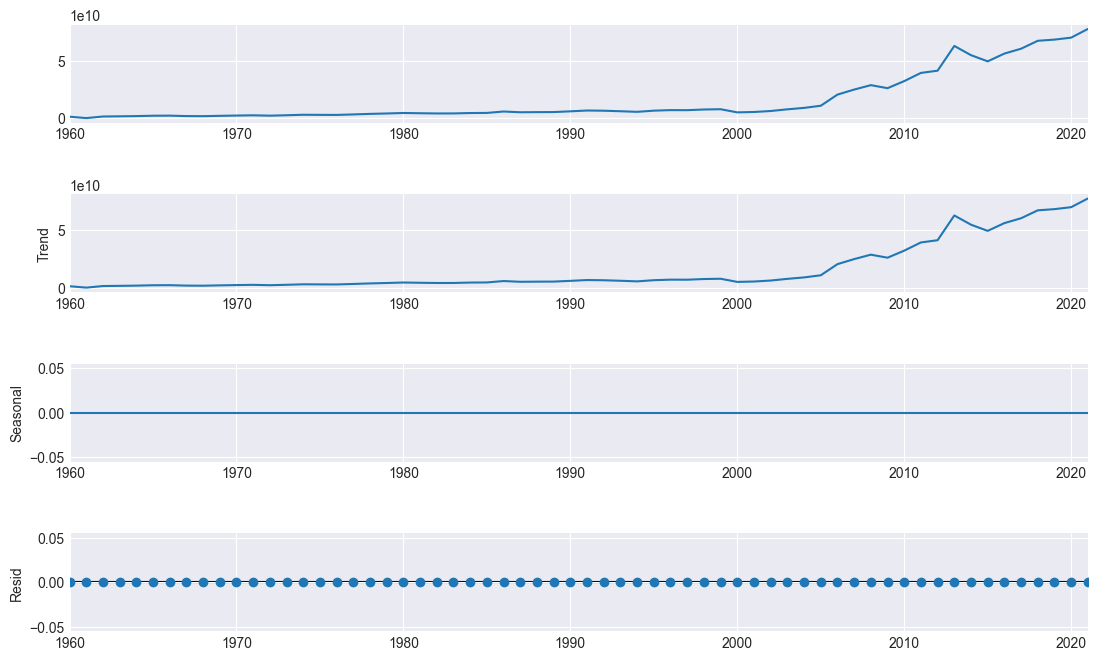

In [16]:
decomposed_data = seasonal_decompose(data)
figure = decomposed_data.plot()
figure.set_figwidth(12)
figure.set_figheight(7)
plt.show();

В данных есть тренд (график которого совпадает с графиком исходных данных), полностью отсутствует сезонность, шум находится в нуле.

Разделим выборку на *train* и *test*, в тестовой оставим последние 3 года.

In [17]:
train, test = data[data.index.year < 2019], data[data.index.year >= 2019]
print(
    'Train shape:', train.shape,
    '\nTest shape:', test.shape
)

Train shape: (59, 1) 
Test shape: (3, 1)


## Построение графика скользящего среднего

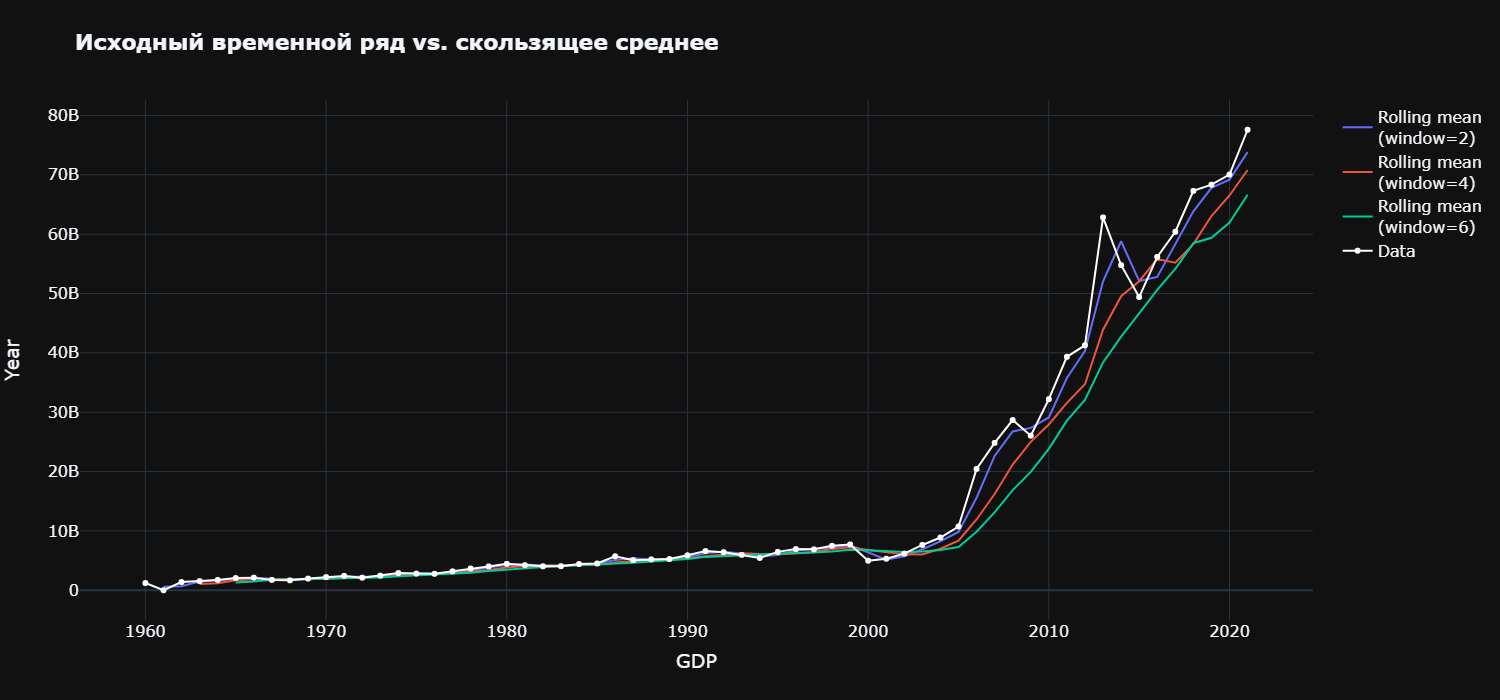

In [18]:
fig = go.Figure()
for window in range(2, 7, 2):
    rolling_data = data.rolling(window=window).mean()
    fig.add_trace(
        go.Scatter(
            x=rolling_data.index,
            y=rolling_data.GDP,
            name=f'Rolling mean<br>(window={window})',
        )
    )
fig.add_trace(
    go.Scatter(
        x=data.index,
        y=data.GDP,
        name='Data',
        mode='lines+markers',
        line=dict(color='white')
    )
).update_layout(
    width=1500,
    height=700,
    title='<b>Исходный временной ряд vs. скользящее среднее</b>',
    xaxis_title='GDP',
    yaxis_title='Year',
    font=dict(size=16)
)
fig.show()

Скользящее среднее с окном 3 довольно хорошо описывает исходные данные, но есть некоторые неточности, например, промежуток между 2013 и 2015 годами.

## Оценка ряда на стационарность, выбор модели *ARMA/ARIMA*

In [19]:
adfuller_result = adfuller(data)
if adfuller_result[0] > adfuller_result[4]['5%']: 
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')

Ряд нестационарен


Количество дифференцирований, необходимых для сведения ряда к стационарному: 3


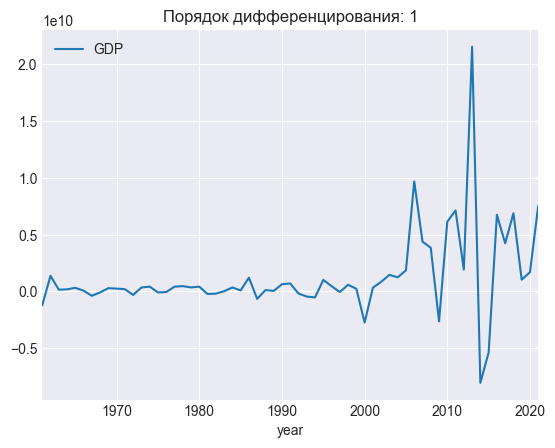

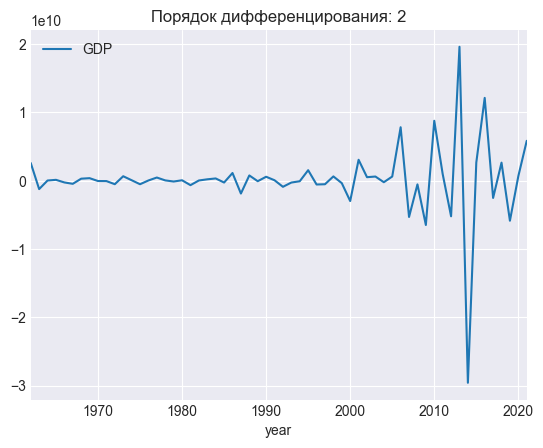

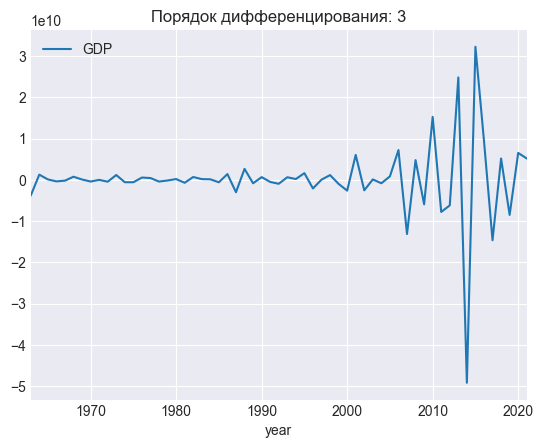

In [20]:
def num_of_diffs(data):
    n_diff = 0
    data_diff = data.diff().dropna()
    while True:
        n_diff += 1
        adfuller_result = adfuller(data_diff)
        data_diff.plot().set_title(f'Порядок дифференцирования: {n_diff}')
        if adfuller_result[0] <= adfuller_result[4]['10%']:
            break
        data_diff = data_diff.diff().dropna()
    print(f'Количество дифференцирований, необходимых для сведения ряда к стационарному: {n_diff}')
    
plt.show()
num_of_diffs(data)

Параметр `d=3`, полагаясь тест Дики-Фуллера.

Т.к. исходные данные нестационарны, то будем использовать *ARIMA*.

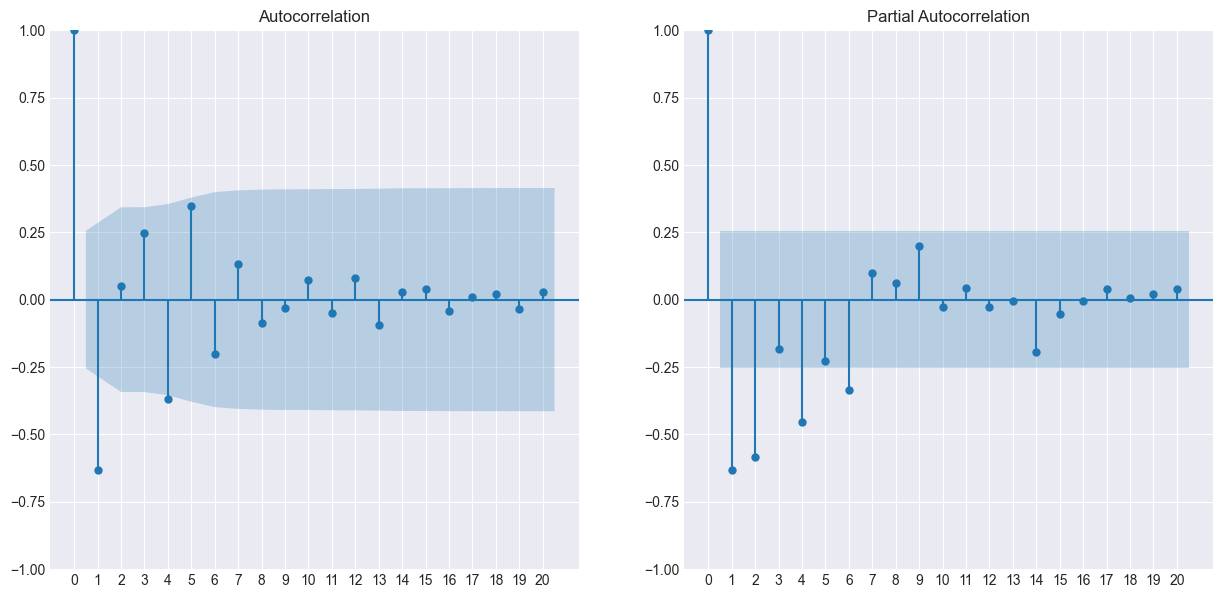

In [21]:
data_diff = data['GDP'].diff().diff().diff().dropna()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
plot_acf(x=data_diff, ax=ax[0], lags=20)
plot_pacf(x=data_diff, ax=ax[1], lags=20, method='ywm')
ax[0].xaxis.set_ticks(range(0, 21))
ax[1].xaxis.set_ticks(range(0, 21))
plt.show()

Из коррелограмм имеем следующее:
* параметр `q=1` (левый график автокорреляции);
* параметр `p=1` (правый график автокорреляции);

Инициализируем модель *ARIMA* с подобранными параметрами, обучим её и узнаем коэффициент *AIC*

In [22]:
p, d, q = 1, 3, 1
arima = ARIMA(train, order=(p, d, q)).fit()
arima.aic

2670.9100753144694

Попробуем подобрать параметры автоматически с помощью `pmdarima`

In [23]:
best_arima = auto_arima(
    y=train,
    start_p=1,
    start_q=1,
    d=3,
    max_p=6,
    max_q=6,
    seasonal=False
)

print(
    'AIC:', best_arima.aic(),
    '\nParams:', best_arima.order
)

AIC: 2659.230811357536 
Params: (2, 3, 1)


Изменилось только значение `p` с 1 на 2, *AIC* уменьшился на $\approx 11$.

Визуализируем предсказания модели с наилучшими подобранными параметрами.

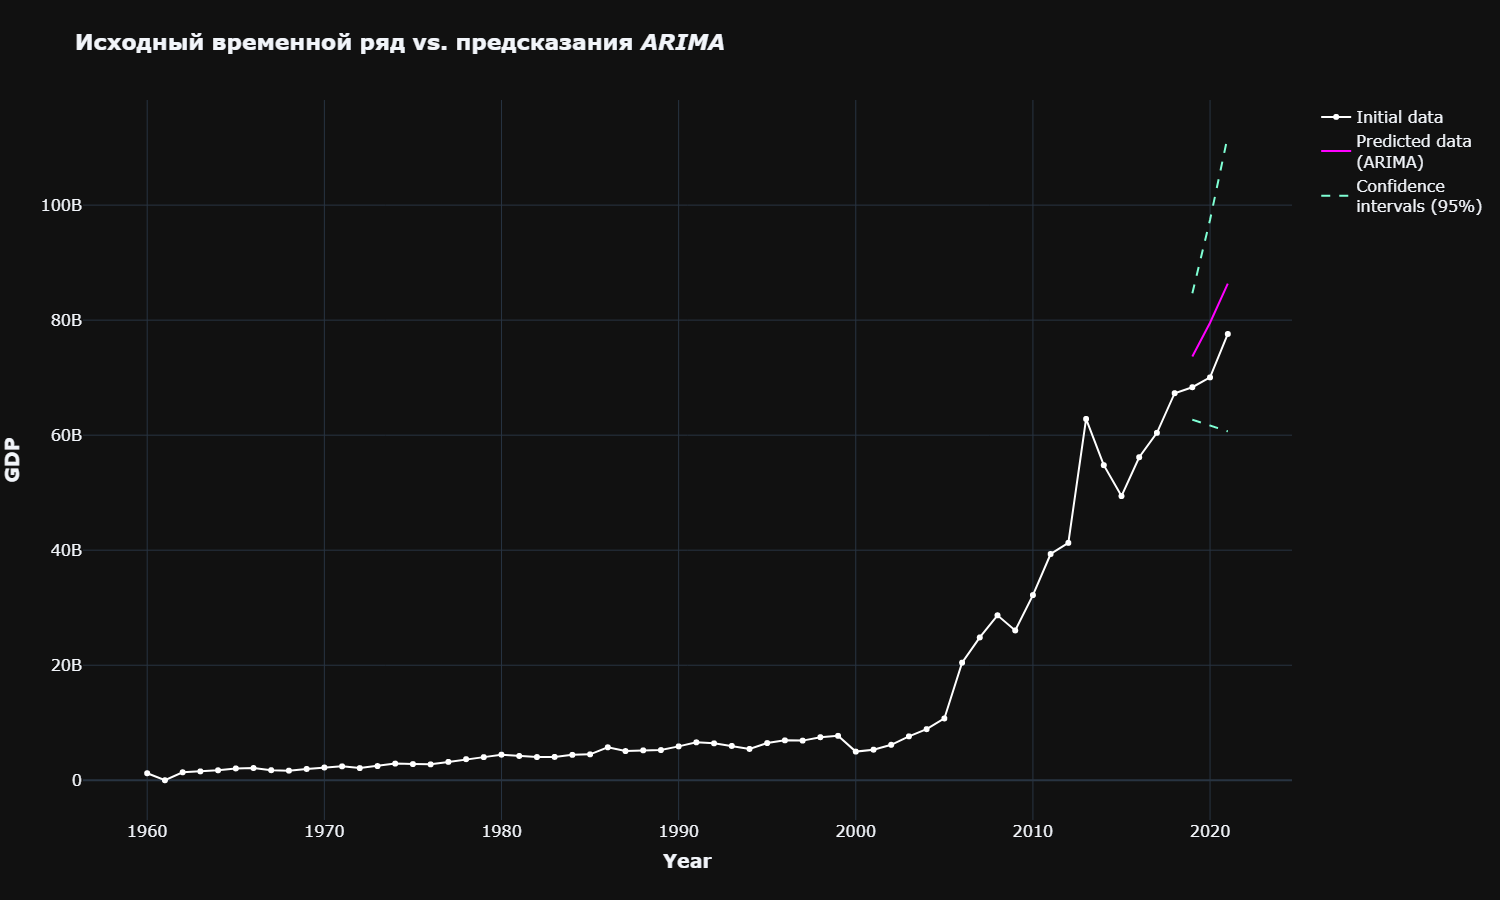

In [24]:
y_pred, conf_int = best_arima.predict(3, return_conf_int=True, alpha=0.05)
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=data.index,
        y=data['GDP'],
        name='Initial data',
        line=dict(color='white'),
        mode='lines+markers'
    )
).add_trace(
    go.Scatter(
        x=y_pred.index,
        y=y_pred.values,
        name='Predicted data<br>(ARIMA)',
        line=dict(color='#FF00FF'),
        mode='lines'
    )
).add_trace(
    go.Scatter(
        x=y_pred.index,
        y=conf_int[:, 0],
        line=dict(color='#7FFFD4'),
        line_dash='dash',
        mode='lines',
        name='Confidence<br>intervals (95%)'
    )
).add_trace(
    go.Scatter(
        x=y_pred.index,
        y=conf_int[:, 1],
        line=dict(color='#7FFFD4'),
        line_dash='dash',
        mode='lines',
        showlegend=False
    )
).update_layout(
    width=1500,
    height=900,
    title='<b>Исходный временной ряд vs. предсказания <i>ARIMA</i></b>',
    font=dict(size=16),
    xaxis_title='<b>Year</b>',
    yaxis_title='<b>GDP</b>'
)
fig.show()

## Вывод
Хоть модель немного завысила реальные показатели, но по графику видно, что получилось выявить зависимость, и модель можно использовать для примерных предсказаний на будущее.
# <center>Интерполяция и сэмплирование
**Проверка пропущенных значений для всех дат на начало года**

In [36]:
data.asfreq('AS').isna().sum()

GDP    0
dtype: int64

Пропущенных значений для дат не найдено  
**Проверка пропущенных значений, скрывающимися за нулями**

In [41]:
data[data['GDP'] == 0]

,GDP
year,
1961-01-01,0.0


Есть 1 пропуск, заполненный нулём.  
**Замена пропуска на `np.nan`**

In [42]:
data['GDP'] = data['GDP'].apply(lambda x: np.nan if x==0 else x)

**Заполнение пропущенного значения с использованием интерполяции**

In [43]:
data['GDP'].interpolate(method='linear', inplace=True)

**Проверка на стационарность**

In [44]:
adfuller_result = adfuller(data)
if adfuller_result[0] > adfuller_result[4]['5%']: 
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')

Ряд нестационарен


**Подбираем порядок дифференцирования**

Количество дифференцирований, необходимых для сведения ряда к стационарному: 3


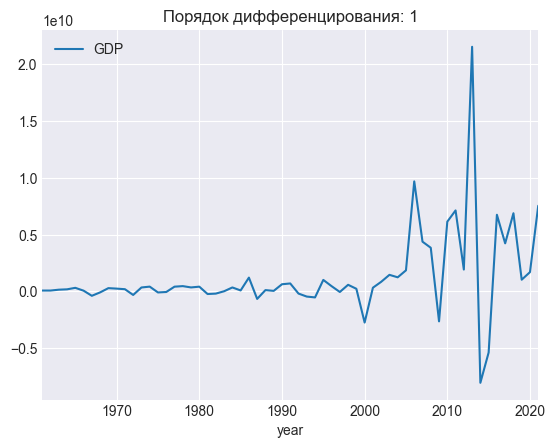

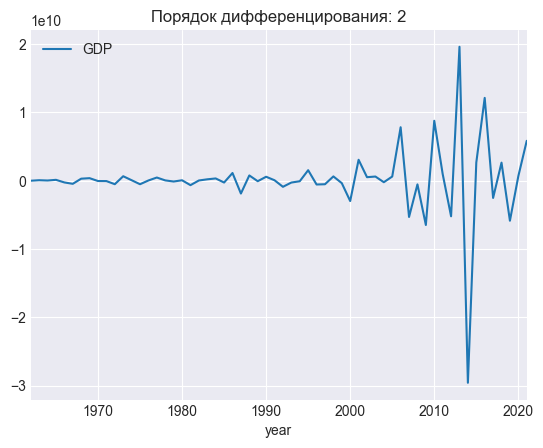

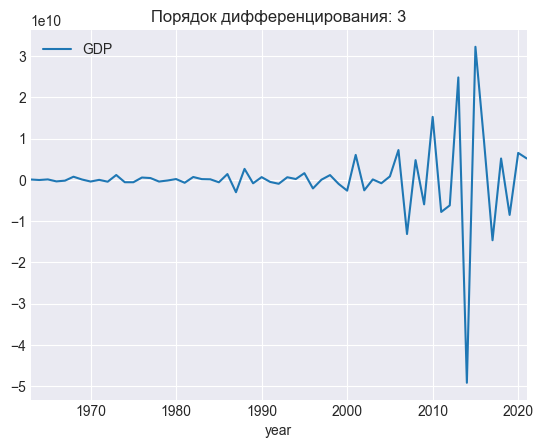

In [45]:
num_of_diffs(data)

**Построение коррелограмм**

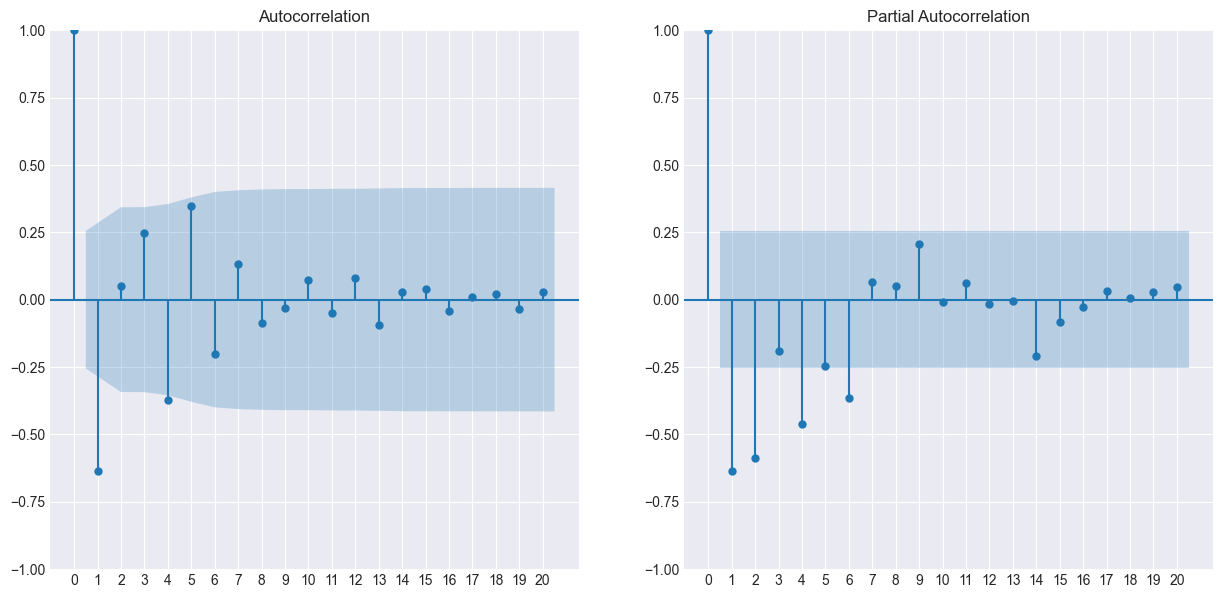

In [46]:
data_diff = data['GDP'].diff().diff().diff().dropna()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
plot_acf(x=data_diff, ax=ax[0], lags=20)
plot_pacf(x=data_diff, ax=ax[1], lags=20, method='ywm')
ax[0].xaxis.set_ticks(range(0, 21))
ax[1].xaxis.set_ticks(range(0, 21))
plt.show()

**Подбор параметров для *ARIMA***

In [47]:
best_arima = auto_arima(
    y=train,
    start_p=1,
    start_q=1,
    d=3,
    max_p=6,
    max_q=6,
    seasonal=False
)

print(
    'AIC:', best_arima.aic(),
    '\nParams:', best_arima.order
)

AIC: 2659.230811357536 
Params: (2, 3, 1)


Значение не поменялось (без интерполяции тоже было $2659$).
## Вывод
Интерполирование одного пропущенного значения никак не повлияло на качество модели *ARIMA*.